In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
# fixar random seed para se puder reproduzir os resultados
seed = 9
np.random.seed(seed)

In [23]:
def get_stock_data(stock_name, normalized=0,file_name=None):
    if not file_name:
        file_name ='table.csv'%stock_name
    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(file_name, header=0, names=col_names) #fica numa especie de tabela exactamente como estava no csv (1350 linhas,7 colunas)
    df = pd.DataFrame(stocks) #neste caso não vai fazer nada
    date_split = df['Date'].str.split('-').str #não vai servir para nada
    df['Year'], df['Month'], df['Day'] = date_split #não vai servir para nada
    df["Volume"] = df["Volume"] / 10000 #não vai servir para nada
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) #vou só ficar com as colunas 1,2,4
    return df

In [24]:
def load_GOOGL_stock_dataset():
    stock_name = 'GOOGL'
    return get_stock_data(stock_name,0, 'table.csv')

def pre_processar_GOOGL_stock_dataset(df):
    df['High'] = df['High'] / 100
    df['Open'] = df['Open'] / 100
    df['Close'] = df['Close'] / 100
    return df

# Visualizar os top registos da tabela
def visualize_GOOGL():
    df = load_GOOGL_stock_dataset()
    print('### Antes do pré-processamento ###')
    print(df.head()) #mostra só os primeiros 5 registos
    df = pre_processar_GOOGL_stock_dataset(df)
    print('### Após o pré-processamento ###')
    print(df.head())

In [25]:
#função load_data do lstm.py configurada para aceitar qualquer número de parametros
#o último atributo é que fica como label (resultado)
#stock é um dataframe do pandas (uma especie de dicionario + matriz)
#seq_len é o tamanho da janela a ser utilizada na serie temporal
def load_data(df_dados, janela):
    qt_atributos = len(df_dados.columns)
    mat_dados = df_dados.as_matrix() #converter dataframe para matriz (lista com lista de cada registo)
    tam_sequencia = janela + 1
    res = []
    for i in range(len(mat_dados) - tam_sequencia): #numero de registos - tamanho da sequencia
         res.append(mat_dados[i: i + tam_sequencia])
    res = np.array(res) #dá como resultado um np com uma lista de matrizes (janela deslizante ao longo da serie)
    qt_casos_treino = int(round(0.9 * res.shape[0])) #90% passam a ser casos de treino
    train = res[:qt_casos_treino, :]
    x_train = train[:, :-1] #menos um registo pois o ultimo registo é o registo a seguir à janela
    y_train = train[:, -1][:,-1] #para ir buscar o último atributo para a lista dos labels
    x_test = res[qt_casos_treino:, :-1]
    y_test = res[qt_casos_treino:, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], qt_atributos))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], qt_atributos))
    return [x_train, y_train, x_test, y_test]

In [26]:
# Etapa 2 - Definir a topologia da rede (arquitectura do modelo) e compilar '''
def build_model2(janela):
    model = Sequential()
    model.add(LSTM(128, input_shape=(janela, 3), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, input_shape=(janela, 3), return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="linear", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [27]:
#imprime um grafico com os valores de teste e com as correspondentes tabela de previsões
def print_series_prediction(y_test,predic):
    diff=[]
    racio=[]
    for i in range(len(y_test)): #para imprimir tabela de previsoes
        racio.append( (y_test[i]/predic[i])-1)
        diff.append( abs(y_test[i]- predic[i]))
        print('valor: %f ---> Previsão: %f Diff: %f Racio: %f' % (y_test[i],predic[i], diff[i],racio[i]))
    plt.plot(y_test,color='blue', label='y_test')
    plt.plot(predic,color='red', label='prediction') #este deu uma linha em branco
    plt.plot(diff,color='green', label='diff')
    plt.plot(racio,color='yellow', label='racio')
    plt.legend(loc='upper left')
    plt.show()

In [28]:
def LSTM_utilizando_GOOGL_data():
    df = load_GOOGL_stock_dataset()
    df = pre_processar_GOOGL_stock_dataset(df)
    print("df", df.shape)
    janela = 22 #tamanho da Janela deslizante
    X_train, y_train, X_test, y_test = load_data(df[::-1], janela)# o df[::-1] é o df por ordem inversa
    print("X_train", X_train.shape)
    print("y_train", y_train.shape)
    print("X_test", X_test.shape)
    print("y_test", y_test.shape)
    #model = build_model(janela)
    model = build_model2(janela)
    #model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=0.1, verbose=1)
    print_model(model,"lstm_model.png")
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    print(model.metrics_names)
    p = model.predict(X_test)
    predic = np.squeeze(np.asarray(p)) #para transformar uma matriz de uma coluna e n linhas em um np array de n elementos
    print_series_prediction(y_test,predic)
    # MSE- (Mean square error), RMSE- (root mean square error) - 
    # o significado de RMSE depende do range da label. para o mesmo range menor é melhor.

In [29]:
def print_model(model,fich):
 from keras.utils import plot_model
 plot_model(model, to_file=fich, show_shapes=True, show_layer_names=True)

df (1350, 3)
X_train (1194, 22, 3)
y_train (1194,)
X_test (133, 22, 3)
y_test (133,)


C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Train on 1074 samples, validate on 120 samples
Epoch 1/500
1074/1074 [==============================] - 2s 2ms/step - loss: 54.6070 - acc: 0.0000e+00 - val_loss: 57.5957 - val_acc: 0.0000e+00
Epoch 2/500
1074/1074 [==============================] - 0s 377us/step - loss: 54.1374 - acc: 0.0000e+00 - val_loss: 57.0660 - val_acc: 0.0000e+00
Epoch 3/500
1074/1074 [==============================] - 0s 361us/step - loss: 53.6271 - acc: 0.0000e+00 - val_loss: 56.4425 - val_acc: 0.0000e+00
Epoch 4/500
1074/1074 [==============================] - 0s 372us/step - loss: 53.0120 - acc: 0.0000e+00 - val_loss: 55.6395 - val_acc: 0.0000e+00
Epoch 5/500
1074/1074 [==============================] - 0s 368us/step - loss: 52.2080 - acc: 0.0000e+00 - val_loss: 54.5500 - val_acc: 0.0000e+00
Epoch 6/500
1074/1074 [==============================] - 0s 372us/step - loss: 51.1285 - acc: 0.0000e+00 - val_loss: 53.1437 - val_acc: 0.0000e+00
Epoch 7/500
1074/1074 [==============================] - 0s 352us/step - 

1074/1074 [==============================] - 1s 495us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3223 - val_acc: 0.0000e+00
Epoch 57/500
1074/1074 [==============================] - 1s 496us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3278 - val_acc: 0.0000e+00
Epoch 58/500
1074/1074 [==============================] - 1s 503us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3333 - val_acc: 0.0000e+00
Epoch 59/500
1074/1074 [==============================] - 1s 521us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3349 - val_acc: 0.0000e+00
Epoch 60/500
1074/1074 [==============================] - 1s 487us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3343 - val_acc: 0.0000e+00
Epoch 61/500
1074/1074 [==============================] - 1s 502us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3338 - val_acc: 0.0000e+00
Epoch 62/500
1074/1074 [==============================] - 1s 476us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3322 - val_acc: 0.

1074/1074 [==============================] - 1s 510us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3504 - val_acc: 0.0000e+00
Epoch 113/500
1074/1074 [==============================] - 1s 506us/step - loss: 3.1091 - acc: 0.0000e+00 - val_loss: 0.3411 - val_acc: 0.0000e+00
Epoch 114/500
1074/1074 [==============================] - 1s 480us/step - loss: 3.1082 - acc: 0.0000e+00 - val_loss: 0.3441 - val_acc: 0.0000e+00
Epoch 115/500
1074/1074 [==============================] - 1s 502us/step - loss: 3.1081 - acc: 0.0000e+00 - val_loss: 0.3503 - val_acc: 0.0000e+00
Epoch 116/500
1074/1074 [==============================] - 1s 491us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3526 - val_acc: 0.0000e+00
Epoch 117/500
1074/1074 [==============================] - 1s 512us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3470 - val_acc: 0.0000e+00
Epoch 118/500
1074/1074 [==============================] - 1s 487us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3362 - val_a

Epoch 168/500
1074/1074 [==============================] - 0s 346us/step - loss: 3.1080 - acc: 0.0000e+00 - val_loss: 0.3605 - val_acc: 0.0000e+00
Epoch 169/500
1074/1074 [==============================] - 0s 342us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3715 - val_acc: 0.0000e+00
Epoch 170/500
1074/1074 [==============================] - 0s 344us/step - loss: 3.1093 - acc: 0.0000e+00 - val_loss: 0.3755 - val_acc: 0.0000e+00
Epoch 171/500
1074/1074 [==============================] - 0s 340us/step - loss: 3.1095 - acc: 0.0000e+00 - val_loss: 0.3756 - val_acc: 0.0000e+00
Epoch 172/500
1074/1074 [==============================] - 0s 341us/step - loss: 3.1094 - acc: 0.0000e+00 - val_loss: 0.3662 - val_acc: 0.0000e+00
Epoch 173/500
1074/1074 [==============================] - 0s 342us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3514 - val_acc: 0.0000e+00
Epoch 174/500
1074/1074 [==============================] - 0s 342us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 

Epoch 224/500
1074/1074 [==============================] - 0s 345us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3271 - val_acc: 0.0000e+00
Epoch 225/500
1074/1074 [==============================] - 0s 358us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3275 - val_acc: 0.0000e+00
Epoch 226/500
1074/1074 [==============================] - 0s 350us/step - loss: 3.1086 - acc: 0.0000e+00 - val_loss: 0.3393 - val_acc: 0.0000e+00
Epoch 227/500
1074/1074 [==============================] - 0s 349us/step - loss: 3.1074 - acc: 0.0000e+00 - val_loss: 0.3637 - val_acc: 0.0000e+00
Epoch 228/500
1074/1074 [==============================] - 0s 348us/step - loss: 3.1098 - acc: 0.0000e+00 - val_loss: 0.3874 - val_acc: 0.0000e+00
Epoch 229/500
1074/1074 [==============================] - 0s 346us/step - loss: 3.1108 - acc: 0.0000e+00 - val_loss: 0.3901 - val_acc: 0.0000e+00
Epoch 230/500
1074/1074 [==============================] - 0s 356us/step - loss: 3.1104 - acc: 0.0000e+00 - val_loss: 

Epoch 280/500
1074/1074 [==============================] - 0s 343us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3430 - val_acc: 0.0000e+00
Epoch 281/500
1074/1074 [==============================] - 0s 345us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3542 - val_acc: 0.0000e+00
Epoch 282/500
1074/1074 [==============================] - 0s 345us/step - loss: 3.1084 - acc: 0.0000e+00 - val_loss: 0.3572 - val_acc: 0.0000e+00
Epoch 283/500
1074/1074 [==============================] - 0s 342us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3582 - val_acc: 0.0000e+00
Epoch 284/500
1074/1074 [==============================] - 0s 358us/step - loss: 3.1087 - acc: 0.0000e+00 - val_loss: 0.3488 - val_acc: 0.0000e+00
Epoch 285/500
1074/1074 [==============================] - 0s 348us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 0.3442 - val_acc: 0.0000e+00
Epoch 286/500
1074/1074 [==============================] - 0s 359us/step - loss: 3.1085 - acc: 0.0000e+00 - val_loss: 

Epoch 336/500
1074/1074 [==============================] - 0s 354us/step - loss: 3.1078 - acc: 0.0000e+00 - val_loss: 0.3616 - val_acc: 0.0000e+00
Epoch 337/500
1074/1074 [==============================] - 0s 364us/step - loss: 3.1080 - acc: 0.0000e+00 - val_loss: 0.3903 - val_acc: 0.0000e+00
Epoch 338/500
1074/1074 [==============================] - 0s 359us/step - loss: 3.1121 - acc: 0.0000e+00 - val_loss: 0.4105 - val_acc: 0.0000e+00
Epoch 339/500
1074/1074 [==============================] - 0s 346us/step - loss: 3.1134 - acc: 0.0000e+00 - val_loss: 0.4128 - val_acc: 0.0000e+00
Epoch 340/500
1074/1074 [==============================] - 0s 348us/step - loss: 3.1136 - acc: 0.0000e+00 - val_loss: 0.4187 - val_acc: 0.0000e+00
Epoch 341/500
1074/1074 [==============================] - 0s 362us/step - loss: 3.1146 - acc: 0.0000e+00 - val_loss: 0.4174 - val_acc: 0.0000e+00
Epoch 342/500
1074/1074 [==============================] - 0s 345us/step - loss: 3.1145 - acc: 0.0000e+00 - val_loss: 

Epoch 392/500
1074/1074 [==============================] - 0s 353us/step - loss: 3.1088 - acc: 0.0000e+00 - val_loss: 0.3482 - val_acc: 0.0000e+00
Epoch 393/500
1074/1074 [==============================] - 0s 348us/step - loss: 3.1083 - acc: 0.0000e+00 - val_loss: 0.3565 - val_acc: 0.0000e+00
Epoch 394/500
1074/1074 [==============================] - 0s 346us/step - loss: 3.1101 - acc: 0.0000e+00 - val_loss: 0.3725 - val_acc: 0.0000e+00
Epoch 395/500
1074/1074 [==============================] - 0s 361us/step - loss: 3.1093 - acc: 0.0000e+00 - val_loss: 0.3692 - val_acc: 0.0000e+00
Epoch 396/500
1074/1074 [==============================] - 0s 347us/step - loss: 3.1089 - acc: 0.0000e+00 - val_loss: 0.3601 - val_acc: 0.0000e+00
Epoch 397/500
1074/1074 [==============================] - 0s 353us/step - loss: 3.1092 - acc: 0.0000e+00 - val_loss: 0.3367 - val_acc: 0.0000e+00
Epoch 398/500
1074/1074 [==============================] - 0s 346us/step - loss: 3.1074 - acc: 0.0000e+00 - val_loss: 

Epoch 448/500
1074/1074 [==============================] - 0s 372us/step - loss: 2.7836 - acc: 0.0000e+00 - val_loss: 0.2435 - val_acc: 0.0000e+00
Epoch 449/500
1074/1074 [==============================] - 0s 380us/step - loss: 2.7717 - acc: 0.0000e+00 - val_loss: 0.2106 - val_acc: 0.0000e+00
Epoch 450/500
1074/1074 [==============================] - 0s 386us/step - loss: 2.7520 - acc: 0.0000e+00 - val_loss: 0.2110 - val_acc: 0.0000e+00
Epoch 451/500
1074/1074 [==============================] - 0s 368us/step - loss: 2.7305 - acc: 0.0000e+00 - val_loss: 0.2174 - val_acc: 0.0000e+00
Epoch 452/500
1074/1074 [==============================] - 0s 369us/step - loss: 2.7132 - acc: 0.0000e+00 - val_loss: 0.2310 - val_acc: 0.0000e+00
Epoch 453/500
1074/1074 [==============================] - 0s 371us/step - loss: 2.6957 - acc: 0.0000e+00 - val_loss: 0.2249 - val_acc: 0.0000e+00
Epoch 454/500
1074/1074 [==============================] - 0s 372us/step - loss: 2.6837 - acc: 0.0000e+00 - val_loss: 

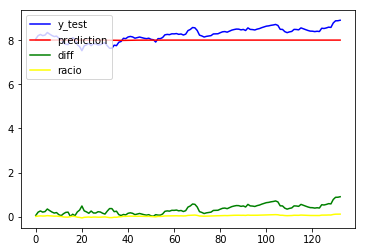

In [30]:
if __name__ == '__main__':
 #visualize_GOOGL()
 LSTM_utilizando_GOOGL_data()